In [73]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Image, display


Модуль 4

1. Загрузка и предобработка больших данных

1.1. Загрузка данных

In [18]:
path = "/home/c9/Загрузки/BIG DATA/"

In [19]:
y = pd.read_csv(path + "target_1.csv")
y

0            1
0         2119.599629  2079.442098
1          722.731326  1220.528290
2         3874.563274  4070.216819
3         4103.015622  4620.921611
4         4638.387753  5066.169785
...               ...          ...
29999995  4934.591268  4492.057455
29999996  3721.071517  3839.880560
29999997  4516.125168  4323.499011
29999998  2497.450356  3657.470193
29999999  3622.133027  3807.923494

[30000000 rows x 2 columns]

In [20]:
y = pd.read_csv(path + "target_2.csv")
y

0            1
0         4554.463731  5092.295833
1         2809.094632  2310.743036
2         2975.076596  3887.040957
3         3534.584709  3437.476122
4         3457.193953  4166.549638
...               ...          ...
29999995  2186.988521  3225.650558
29999996  1747.469170  1802.054040
29999997  2980.523310  3492.938488
29999998  4230.753167  5132.415885
29999999  3464.084451  3485.730654

[30000000 rows x 2 columns]

In [21]:
y = pd.read_csv(path + "target_3.csv")
y

0            1
0         1172.307480  1552.313722
1         2878.755179  5011.740084
2         1289.382498  2307.292548
3         1270.259808   793.485448
4         2621.551010  3001.258471
...               ...          ...
29999995  1686.177117  2548.015451
29999996   411.562852   427.868659
29999997  1560.314516  1429.640703
29999998  5067.120696  5457.021583
29999999  1614.770027  2162.377406

[30000000 rows x 2 columns]

In [22]:
row_size = 30000000

In [23]:
memory_usage = y.memory_usage(deep=True)  # Вычисляем память и получаем результат
1136024221 / memory_usage.sum()

np.float64(2.366716476236302)

In [24]:
y = dd.read_csv(path + "target_2.csv")
memory_usage = y.memory_usage(deep=True).compute()
1136024221 / memory_usage.sum()

np.float64(2.36670606273249)

In [25]:
y = dd.read_csv(path + "df_3.csv")
memory_usage = y.memory_usage(deep=True).compute()
memory_usage.sum() / 1024 / 1024 / 1024

np.float64(6.705555729568005)

In [91]:
xx = [ 0, 1, 2, 3 ]

In [109]:
f = True
mmin = 0
mmax = 0
corr = []
for x in xx:
    df = pd.read_csv(path + f"df_{x}.csv")
    target = pd.read_csv(path + f"target_{x}.csv")
    df['t0'] = target['0']
    df['t1'] = target['1']
    print(f"load{x}")
    if f:
        mmin = df.min()
    else:
        mmin = pd.concat([mmin, df.min()], axis=1).min(axis=1)
    if f:
        mmax = df.max()
    else:
        mmax = pd.concat([mmax, df.max()], axis=1).max(axis=1)
    c = df.corr(method='pearson')
    if f:
        corr = c
    else:
        corr += c
    print(f"sgr{x}")
    plt.figure(figsize=(60, 120))
    for i, col in enumerate(df.columns):
        plt.subplot(len(df.columns), 1, i + 1)  # Создание подграфиков
        df[col].hist(bins=30, edgecolor='black')
        plt.title(f'Гистограмма параметра {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')

    plt.savefig(f'df{x}.png')  # Сохраните график в формате PNG
    plt.close()
    print(f"end{x}")
    f = False

load0
sgr0
end0
load1
sgr1
end1
load2
sgr2
end2
load3
sgr3
end3


b Графики распределения параметров (по 1 графику для каждого файла)

In [110]:
display(Image(filename='df0.png'))

In [111]:
display(Image(filename='df1.png'))

In [112]:
display(Image(filename='df2.png'))

In [113]:
display(Image(filename='df3.png'))

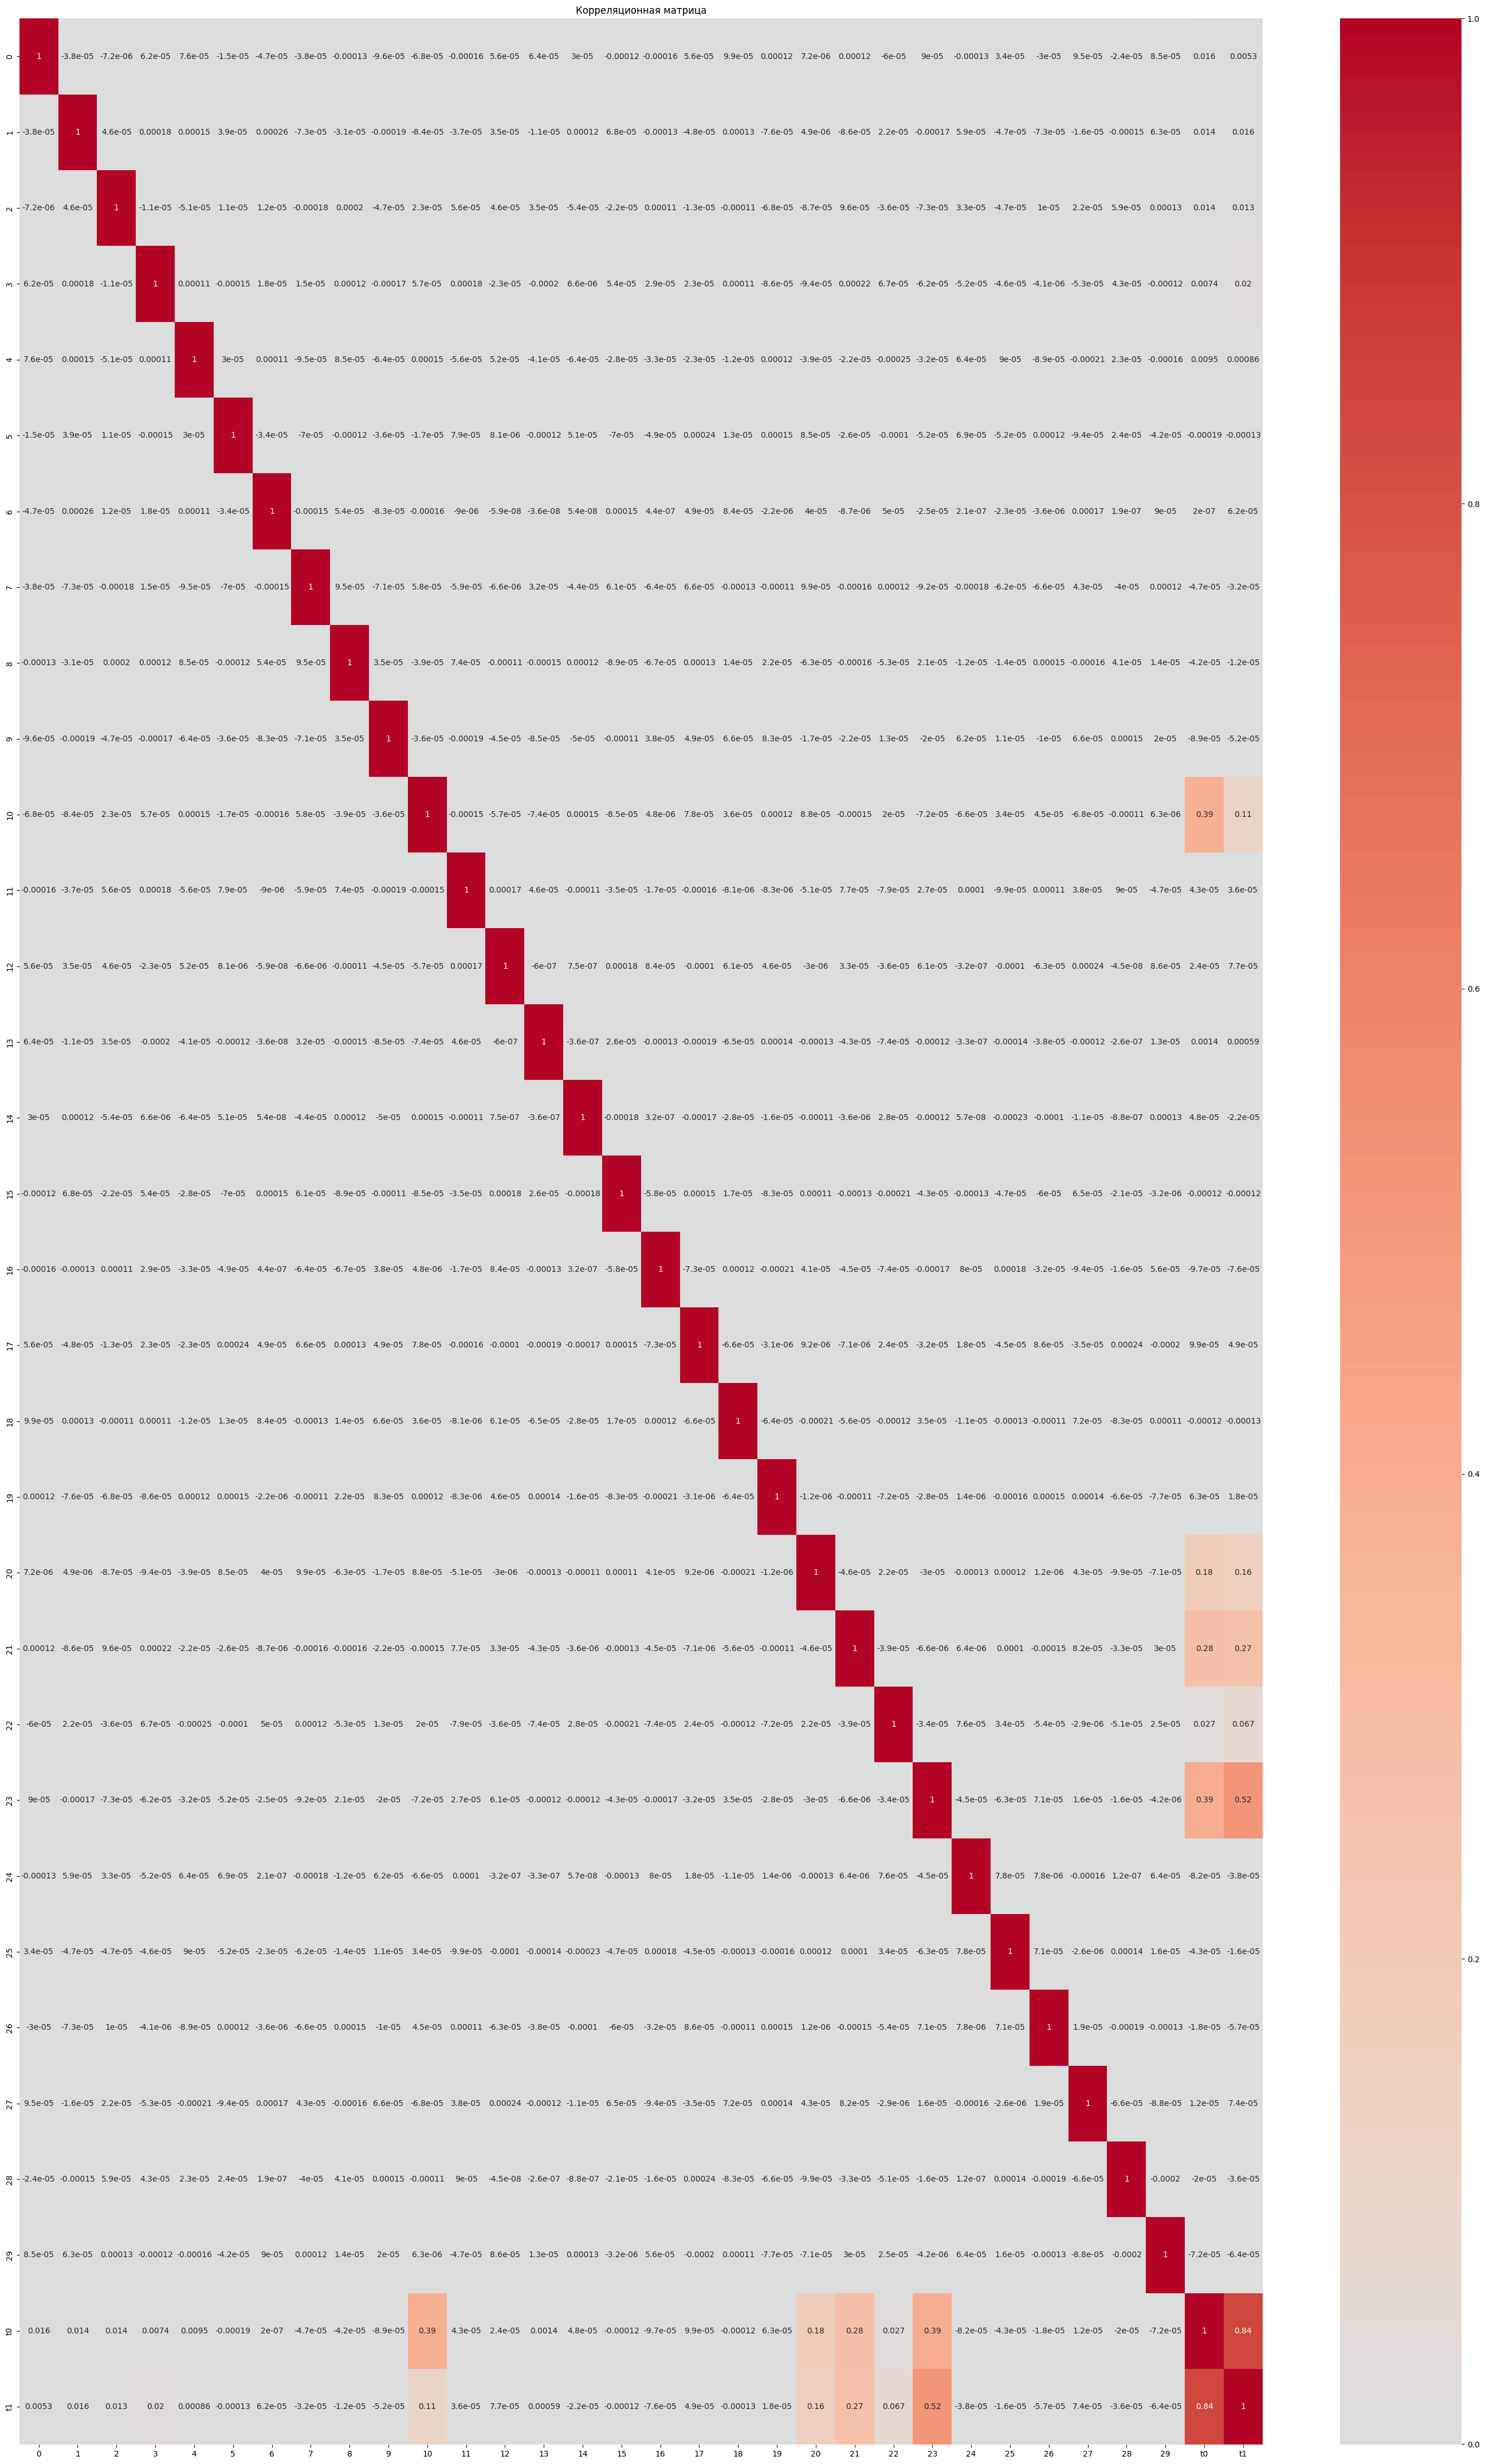

In [114]:
corr = corr / len(xx)
plt.figure(figsize=(35, 55))

# Создание тепловой карты
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)

# Настройка заголовка и отображение графика
plt.title('Корреляционная матрица')
plt.show()

In [129]:
coef = 0.001
good_var = corr[(corr['t0'].abs() >= coef) & (corr['t1'].abs() >= coef)].index.tolist()
good_var

['0', '1', '2', '3', '10', '20', '21', '22', '23', 't0', 't1']

e Судя по таргету данные предназначены для выполнения регрессии + по графикам корреляции выше видно что данные не нормализованы, есть данные которые меняются в относительно широком диапазоне, а есть данные в диапазоне размера около 1.0. Поэтому для лучшего обучения моделей стоит нормализовать данные. Т.к. данные обрабатывались по-файлово было принято решение использовать мин-макс скейлер, т.к. он позволяет определить глобальные минимумы и максимумы для нормализации как минимумы и максимумы локальных минимумов/максимумов соответственно

In [140]:
npath = "datasets/"

In [141]:
m = pd.DataFrame(mmin)
m["1"] = mmax
m.to_csv('min-max.csv', index=False, header=False)

In [158]:
f = True
smemory = 0
ememory = 0
for x in xx:
    df = pd.read_csv(path + f"df_{x}.csv", skiprows=0, nrows=10000000)
    target = pd.read_csv(path + f"target_{x}.csv", skiprows=0, nrows=10000000)
    df['t0'] = target['0']
    df['t1'] = target['1']
    print(f"load{x}")
    df = df[good_var]
    df = (df - mmin[good_var]) / (mmax[good_var] - mmin[good_var])
    smemory += df.memory_usage(deep=True).sum()
    df = df.astype('float16')
    print(f"type{x}")
    ememory += df.memory_usage(deep=True).sum()
    print(f"mm{x}")
    df[['0', '1', '2', '3', '10', '20', '21', '22', '23']].to_csv(npath + f"data_X.csv", index=False, header=False, mode='a')
    df[['t0', 't1']].to_csv(npath + f"data_y.csv", index=False, header=False, mode='a')    
    print(f"end{x}")

load0
type0
mm0
end0
load1
type1
mm1
end1
load2
type2
mm2
end2
load3
type3
mm3
end3


In [160]:
df = pd.read_csv(path + f"df_val.csv", skiprows=0, nrows=10000000)
target = pd.read_csv(path + f"target_val.csv", skiprows=0, nrows=10000000)
df['t0'] = target['0']
df['t1'] = target['1']
print(f"load")
df = df[good_var]
df = (df - mmin[good_var]) / (mmax[good_var] - mmin[good_var])
smemory += df.memory_usage(deep=True).sum()
df = df.astype('float16')
print(f"type")
ememory += df.memory_usage(deep=True).sum()
print(f"mm")
df[['0', '1', '2', '3', '10', '20', '21', '22', '23']].to_csv(npath + f"data_X_val.csv", index=False, header=False, mode='a')
df[['t0', 't1']].to_csv(npath + f"data_y_val.csv", index=False, header=False, mode='a')    
print(f"end")

load
type
mm
end


In [181]:
for x in xx:
    df = pd.read_csv(path + f"df_{x}.csv", skiprows=10000000, nrows=10000000, header=None)
    df.columns = ['0','1','2','3','4','5','6','7','8','9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19','20','21','22','23','24','25','26','27','28','29']
    target = pd.read_csv(path + f"target_{x}.csv", skiprows=10000000, nrows=10000000, header=None)
    target.columns = ["0", "1"]
    df['t0'] = target['0']
    df['t1'] = target['1']
    print(f"load{x}")
    df = df[good_var]
    df = (df - mmin[good_var]) / (mmax[good_var] - mmin[good_var])
    smemory += df.memory_usage(deep=True).sum()
    df = df.astype('float16')
    print(f"type{x}")
    ememory += df.memory_usage(deep=True).sum()
    print(f"mm{x}")
    df[['0', '1', '2', '3', '10', '20', '21', '22', '23']].to_csv(npath + f"data_X.csv", index=False, header=False, mode='a')
    df[['t0', 't1']].to_csv(npath + f"data_y.csv", index=False, header=False, mode='a')    
    print(f"end{x}")

load0
type0
mm0
end0
load1
type1
mm1
end1
load2
type2
mm2
end2
load3
type3
mm3
end3


In [182]:
df = pd.read_csv(path + f"df_val.csv", skiprows=10000000, nrows=10000000, header=None)
df.columns = ['0','1','2','3','4','5','6','7','8','9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19','20','21','22','23','24','25','26','27','28','29']
target = pd.read_csv(path + f"target_val.csv", skiprows=10000000, nrows=10000000, header=None)
target.columns = ["0", "1"]
df['t0'] = target['0']
df['t1'] = target['1']
print(f"load")
df = df[good_var]
df = (df - mmin[good_var]) / (mmax[good_var] - mmin[good_var])
smemory += df.memory_usage(deep=True).sum()
df = df.astype('float16')
print(f"type")
ememory += df.memory_usage(deep=True).sum()
print(f"mm")
df[['0', '1', '2', '3', '10', '20', '21', '22', '23']].to_csv(npath + f"data_X_val.csv", index=False, header=False, mode='a')
df[['t0', 't1']].to_csv(npath + f"data_y_val.csv", index=False, header=False, mode='a')    
print(f"end")

load
type
mm
end


In [183]:
for x in xx:
    df = pd.read_csv(path + f"df_{x}.csv", skiprows=20000000, nrows=10000000, header=None)
    df.columns = ['0','1','2','3','4','5','6','7','8','9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19','20','21','22','23','24','25','26','27','28','29']
    target = pd.read_csv(path + f"target_{x}.csv", skiprows=20000000, nrows=10000000, header=None)
    target.columns = ["0", "1"]
    df['t0'] = target['0']
    df['t1'] = target['1']
    print(f"load{x}")
    df = df[good_var]
    df = (df - mmin[good_var]) / (mmax[good_var] - mmin[good_var])
    smemory += df.memory_usage(deep=True).sum()
    df = df.astype('float16')
    print(f"type{x}")
    ememory += df.memory_usage(deep=True).sum()
    print(f"mm{x}")
    df[['0', '1', '2', '3', '10', '20', '21', '22', '23']].to_csv(npath + f"data_X.csv", index=False, header=False, mode='a')
    df[['t0', 't1']].to_csv(npath + f"data_y.csv", index=False, header=False, mode='a')    
    print(f"end{x}")

load0
type0
mm0
end0
load1
type1
mm1
end1
load2
type2
mm2
end2
load3
type3
mm3
end3


In [184]:
df = pd.read_csv(path + f"df_val.csv", skiprows=20000000, nrows=10000000, header=None)
df.columns = ['0','1','2','3','4','5','6','7','8','9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19','20','21','22','23','24','25','26','27','28','29']
target = pd.read_csv(path + f"target_val.csv", skiprows=20000000, nrows=10000000, header=None)
target.columns = ["0", "1"]
df['t0'] = target['0']
df['t1'] = target['1']
print(f"load")
df = df[good_var]
df = (df - mmin[good_var]) / (mmax[good_var] - mmin[good_var])
smemory += df.memory_usage(deep=True).sum()
df = df.astype('float16')
print(f"type")
ememory += df.memory_usage(deep=True).sum()
print(f"mm")
df[['0', '1', '2', '3', '10', '20', '21', '22', '23']].to_csv(npath + f"data_X_val.csv", index=False, header=False, mode='a')
df[['t0', 't1']].to_csv(npath + f"data_y_val.csv", index=False, header=False, mode='a')    
print(f"end")

load
type
mm
end


In [187]:
(1 - ememory / smemory) * 100

np.float64(74.99998875000169)

In [1]:
output = "output/"

In [ ]:
import zipfile
import os

def zip_directory(folder_path, output_zip):
    # Создание ZIP-архива
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Проход по всем подкаталогам и файлам в указанной директории
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Полный путь к файлу
                file_path = os.path.join(root, file)
                # Добавление файла в архив с сохранением структуры каталогов
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Пример использования
folder_to_zip = 'datasets'  # Замените на путь к вашей директории
output_zip_file = 'output.zip'  # Имя выходного ZIP-файла

zip_directory(folder_to_zip, output_zip_file)